# Question A3

Find the optimal number of hidden neurons for first hidden layer of the 4-layer network (3 hidden layers, output layer) designed in Question 1 and 2

#### Plot the mean cross-validation accuracies on the final epoch for different numbers of hidden-layer neurons using a scatter plot. Limit the search space of the number of neurons to {64, 128, 256}. Continue using 5-fold cross validation on training dataset. Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

This might take a while to run, approximately 20 - 30 min, so plan your time carefully.

1. Firstly, we import relevant libraries.

In [1]:
pip install torch

In [2]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from common_utils import set_seed

# setting seed
set_seed()

2. To reduce repeated code, place your

- network (MLP defined in QA1)
- torch datasets (CustomDataset defined in QA1)
- loss function (loss_fn defined in QA1)

in a separate file called **common_utils.py**

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.

In [3]:
# YOUR CODE HERE
from sklearn.preprocessing import StandardScaler, LabelEncoder
df = pd.read_csv('simplified.csv')

df['label'] = df['filename'].str.split('_').str[-2]

def preprocess_data(df):
    X = df.drop(columns=['filename', 'label']).values
    y = df['label'].values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    return X_scaled, y_encoded

X, y = preprocess_data(df)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

from common_utils import MLP, CustomDataset, loss_fn

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

3. Perform hyperparameter tuning for the different neurons with 5-fold cross validation.

In [4]:
no_features = X_train.shape[1]  
no_hidden = 128  
no_labels = 1
model = MLP(no_features=no_features, no_hidden=no_hidden, no_labels=no_labels)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]

df['label'].value_counts()
def preprocess_data(df):
    X = df.drop(columns=['filename', 'label']).values
    y = df['label'].values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    return X_scaled, y_encoded

X_train, y_train = preprocess_data(df)

from common_utils import EarlyStopper

early_stopper = EarlyStopper(patience=3, min_delta=0)


def train(model, X_train_scaled, y_train2, X_val_scaled, y_val2, batch_size):
    train_accuracies = []
    train_losses = []
    val_accuracies = []
    val_losses = []
    times = []

    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    train_dataset = CustomDataset(X_train_scaled, y_train2)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Loop through epochs
    for epoch in range(100):
        # Training phase
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        start_time = time.time()

        # Loop through batches in the training data
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            labels = labels.float().view(-1, 1)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            predicted = (outputs > 0.5).int()
            correct_train += (predicted == labels.int()).sum().item()
            total_train += labels.size(0)
            
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        # Loop through batches in the validation data
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)

                labels = labels.float().view(-1, 1)

                loss = criterion(outputs, labels)
                val_loss += loss.item()

                predicted = (outputs > 0.5).int()
                correct_val += (predicted == labels.int()).sum().item()
                total_val += labels.size(0)

        # Calculate validation accuracy and loss
        val_accuracy = 100 * correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        end_time = time.time()
        epoch_time = end_time - start_time
        times.append(epoch_time)
        
        if early_stopper.early_stop(val_loss):
            break

    return train_accuracies, train_losses, val_accuracies, val_losses, times

train_accuracies, train_losses, val_accuracies, val_losses, times = train(model, X_train, y_train, X_val, y_val, batch_size=64)

In [5]:
num_epochs = 100
def find_optimal_hyperparameter(X_train, y_train, num_neurons_range, hyperparameter_name, optimal_bs):
    
    cross_validation_accuracies = []
    cross_validation_times = []

    for num_neurons in num_neurons_range:
        fold_accuracies = []
        fold_times = []

        kf = KFold(n_splits=5, shuffle=True, random_state=42)

        for train_index, val_index in kf.split(X_train):
            X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

            train_dataset = CustomDataset(X_train_fold, y_train_fold)
            train_loader = DataLoader(train_dataset, batch_size=optimal_bs, shuffle=True)
            val_dataset = CustomDataset(X_val_fold, y_val_fold)
            val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)

            no_features = X_train_fold.shape[1]
            no_labels = 1
            model = MLP(no_features, num_neurons, no_labels)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adjust learning rate if needed

            start_time = time.time()

            for epoch in range(num_epochs):
                model.train()
                
                for batch_data, batch_labels in train_loader:
                    optimizer.zero_grad()
                    outputs = model(batch_data.float())
                    outputs = outputs.view(-1, 1)
                    batch_labels = batch_labels.view(-1, 1).float()
                    loss = loss_fn(outputs, batch_labels)
                    loss.backward()
                    optimizer.step()

            end_time = time.time()

            model.eval()
            with torch.no_grad():
                for val_data, val_labels in val_loader:
                    val_outputs = model(val_data.float())
                    val_predictions = (val_outputs > 0.5).int()
                    accuracy = (val_predictions == val_labels.int()).float().mean().item()
                    fold_accuracies.append(accuracy)

            fold_times.append(end_time - start_time)

        mean_accuracy = np.mean(fold_accuracies)
        mean_time = np.mean(fold_times)

        cross_validation_accuracies.append(mean_accuracy)
        cross_validation_times.append(mean_time)

        print(f"{hyperparameter_name}={num_neurons}: Mean Accuracy = {mean_accuracy:.4f}, Mean Time = {mean_time:.2f} seconds")

    return cross_validation_accuracies, cross_validation_times

'''
optimal_bs = 0. Fill your optimal batch size in the following code.
'''

num_neurons = [64, 128, 256]
cross_validation_accuracies, cross_validation_times = find_optimal_hyperparameter(X_train, y_train, num_neurons, 'num_neurons', 256)

num_neurons=64: Mean Accuracy = 0.4990, Mean Time = 20.46 seconds
num_neurons=128: Mean Accuracy = 0.4985, Mean Time = 18.21 seconds
num_neurons=256: Mean Accuracy = 0.4988, Mean Time = 18.62 seconds


4. Plot the cross-validation accuracies against the number of epochs for different numbers of hidden-layer neurons. Limit the search space of the number of neurons to {64, 128, 256}.

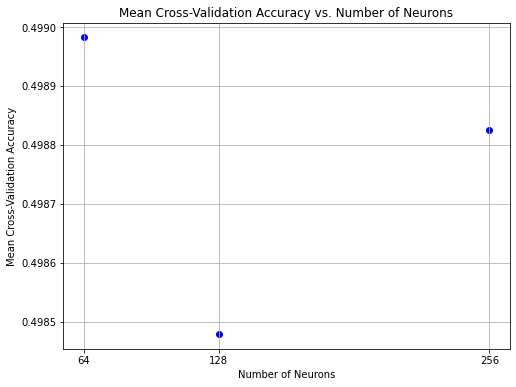

In [6]:
# YOUR CODE HERE
num_neurons_range = [64, 128, 256]

# Plot mean cross-validation accuracies against the number of neurons
plt.figure(figsize=(8, 6))
plt.scatter(num_neurons_range, cross_validation_accuracies, color='blue')
plt.xlabel('Number of Neurons')
plt.ylabel('Mean Cross-Validation Accuracy')
plt.title('Mean Cross-Validation Accuracy vs. Number of Neurons')
plt.xticks(num_neurons_range)
plt.grid(True)
plt.show()

5. Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

In [7]:
optimal_neurons = num_neurons_range[np.argmax(cross_validation_accuracies)]
reason = "The optimal number of neurons is selected based on the highest mean cross-validation accuracy."
print(f"Optimal Number of Neurons: {optimal_neurons}")

Optimal Number of Neurons: 64


6. Plot the train and test accuracies against training epochs with the optimal number of neurons using a line plot.

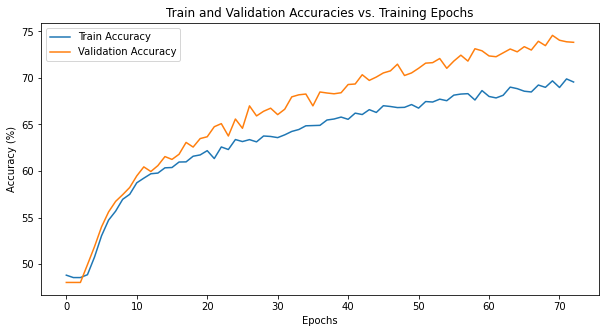

In [8]:
# Plot the train and validation accuracies against training epochs
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Train and Validation Accuracies vs. Training Epochs')
plt.legend()
plt.show()
